# Model-Based RL
In this exercise you will implement a policy and model network which work in tandem to solve the CartPole reinforcement learning problem.

What is a model and why would we want to use one? In this case, a model is going to be a neural network that attempts to learn the dynamics of the real environment. For example, in the CartPole we would like a model to be able to predict the next position of the Cart given the previous position and an action. By learning an accurate model, we can train our agent using the model rather than requiring to use the real environment every time. While this may seem less useful when the real environment is itself a simulation, like in our CartPole task, it can have huge advantages when attempting to learn policies for acting in the physical world.

How are we going to accomplish this in Tensorflow? We are going to be using a neural network that will learn the transition dynamics between a previous observation and action, and the expected new observation, reward, and done state. Our training procedure will involve switching between training our model using the real environment, and training our agent’s policy using the model environment. By using this approach we will be able to learn a policy that allows our agent to solve the CartPole task without actually ever training the policy on the real environment! 

### Loading libraries and starting CartPole environment

In [1]:
from __future__ import print_function
import numpy as np
try:
    import cPickle as pickle
except:
    import pickle
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import math

In [2]:
import sys
if sys.version_info.major > 2:
    xrange = range
del sys

In [3]:
import gym
env = gym.make('CartPole-v0')

/home/u20842/.local/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


### Setting Hyper-parameters

In [4]:
# hyperparameters
H = 8 # number of hidden layer neurons
learning_rate = 1e-2
gamma = 0.99 # discount factor for reward
decay_rate = 0.99 # decay factor for RMSProp leaky sum of grad^2
resume = False # resume from previous checkpoint?

model_bs = 3 # Batch size when learning from model
real_bs = 3 # Batch size when learning from real environment

# model initialization
D = 4 # input dimensionality

### Policy Network

In [5]:
tf.reset_default_graph()
observations = tf.placeholder(tf.float32, [None,4] , name="input_x")
W1 = tf.get_variable("W1", shape=[4, H],
           initializer=tf.contrib.layers.xavier_initializer())
layer1 = tf.nn.relu(tf.matmul(observations,W1))
W2 = tf.get_variable("W2", shape=[H, 1],
           initializer=tf.contrib.layers.xavier_initializer())
score = tf.matmul(layer1,W2)
probability = tf.nn.sigmoid(score)

tvars = tf.trainable_variables()
input_y = tf.placeholder(tf.float32,[None,1], name="input_y")
advantages = tf.placeholder(tf.float32,name="reward_signal")
adam = tf.train.AdamOptimizer(learning_rate=learning_rate)
W1Grad = tf.placeholder(tf.float32,name="batch_grad1")
W2Grad = tf.placeholder(tf.float32,name="batch_grad2")
batchGrad = [W1Grad,W2Grad]

################################################################################
# TODO: Implement the loss function.                                           #
# This sends the weights in the direction of making actions that gave good     #
# advantage (reward overtime) more likely, and actions that didn't less likely.#
################################################################################
loglik = tf.log(input_y*(input_y - probability) + (1 - input_y)*(input_y + probability))
loss = -tf.reduce_mean(loglik * advantages) 
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

newGrads = tf.gradients(loss,tvars)
updateGrads = adam.apply_gradients(zip(batchGrad,tvars))

### Model Network
Here we implement a multi-layer neural network that predicts the next observation, reward, and done state from a current state and action.

In [6]:
mH = 256 # model layer size

input_data = tf.placeholder(tf.float32, [None, 5])
with tf.variable_scope('rnnlm'):
    softmax_w = tf.get_variable("softmax_w", [mH, 50])
    softmax_b = tf.get_variable("softmax_b", [50])

previous_state = tf.placeholder(tf.float32, [None,5] , name="previous_state")
W1M = tf.get_variable("W1M", shape=[5, mH],
           initializer=tf.contrib.layers.xavier_initializer())
B1M = tf.Variable(tf.zeros([mH]),name="B1M")
layer1M = tf.nn.relu(tf.matmul(previous_state,W1M) + B1M)
W2M = tf.get_variable("W2M", shape=[mH, mH],
           initializer=tf.contrib.layers.xavier_initializer())
B2M = tf.Variable(tf.zeros([mH]),name="B2M")
layer2M = tf.nn.relu(tf.matmul(layer1M,W2M) + B2M)
wO = tf.get_variable("wO", shape=[mH, 4],
           initializer=tf.contrib.layers.xavier_initializer())
wR = tf.get_variable("wR", shape=[mH, 1],
           initializer=tf.contrib.layers.xavier_initializer())
wD = tf.get_variable("wD", shape=[mH, 1],
           initializer=tf.contrib.layers.xavier_initializer())

bO = tf.Variable(tf.zeros([4]),name="bO")
bR = tf.Variable(tf.zeros([1]),name="bR")
bD = tf.Variable(tf.ones([1]),name="bD")


predicted_observation = tf.matmul(layer2M,wO,name="predicted_observation") + bO
predicted_reward = tf.matmul(layer2M,wR,name="predicted_reward") + bR
predicted_done = tf.sigmoid(tf.matmul(layer2M,wD,name="predicted_done") + bD)

true_observation = tf.placeholder(tf.float32,[None,4],name="true_observation")
true_reward = tf.placeholder(tf.float32,[None,1],name="true_reward")
true_done = tf.placeholder(tf.float32,[None,1],name="true_done")


predicted_state = tf.concat([predicted_observation,predicted_reward,predicted_done],1)

observation_loss = tf.square(true_observation - predicted_observation)

reward_loss = tf.square(true_reward - predicted_reward)

done_loss = tf.multiply(predicted_done, true_done) + tf.multiply(1-predicted_done, 1-true_done)
done_loss = -tf.log(done_loss)

model_loss = tf.reduce_mean(observation_loss + done_loss + reward_loss)

modelAdam = tf.train.AdamOptimizer(learning_rate=learning_rate)
updateModel = modelAdam.minimize(model_loss)

### Helper-functions

In [7]:
def resetGradBuffer(gradBuffer):
    for ix,grad in enumerate(gradBuffer):
        gradBuffer[ix] = grad * 0
    return gradBuffer

def discount_rewards(r):
    ################################################################################
    # TODO: Implement the discounted rewards function                              #
    # Return discounted rewards weighed by gamma. Each reward will be replaced     #
    # with a weight reward that involves itself and all the other rewards occuring #
    # after it. The later the reward after it happens, the less effect it has on   #
    # the current rewards's discounted reward                                      #
    # Hint: [r0, r1, r2, ..., r_N] will look someting like:                        #
    #       [(r0 + r1*gamma^1 + ... r_N*gamma^N), (r1 + r2*gamma^1 + ...), ...]    #
    ################################################################################
    rnew = np.copy(r)
    for i in range(1, len(rnew)):
        rnew[:len(r)-i] += gamma**i * r[i:]
    return rnew        
    ################################################################################
    #                                 END OF YOUR CODE                             #
    ################################################################################

# This function uses our model to produce a new state when given a previous state and action
def stepModel(sess, xs, action):
    toFeed = np.reshape(np.hstack([xs[-1][0],np.array(action)]),[1,5])
    myPredict = sess.run([predicted_state],feed_dict={previous_state: toFeed})
    reward = myPredict[0][:,4]
    observation = myPredict[0][:,0:4]
    observation[:,0] = np.clip(observation[:,0],-2.4,2.4)
    observation[:,2] = np.clip(observation[:,2],-0.4,0.4)
    doneP = np.clip(myPredict[0][:,5],0,1)
    if doneP > 0.1 or len(xs)>= 300:
        done = True
    else:
        done = False
    return observation, reward, done

## Training the Policy and Model

In [8]:
xs,drs,ys,ds = [],[],[],[]
running_reward = None
reward_sum = 0
episode_number = 1
real_episodes = 1
init = tf.global_variables_initializer()
batch_size = real_bs

drawFromModel = False # When set to True, will use model for observations
trainTheModel = True # Whether to train the model
trainThePolicy = False # Whether to train the policy
switch_point = 1

# Launch the graph
with tf.Session() as sess:
    rendering = False
    sess.run(init)
    observation = env.reset()
    x = observation
    gradBuffer = sess.run(tvars)
    gradBuffer = resetGradBuffer(gradBuffer)
    
    while episode_number <= 5000:
        # Start displaying environment once performance is acceptably high.
        if (reward_sum/batch_size > 150 and drawFromModel == False) or rendering == True : 
            env.render()
            rendering = True
            
        x = np.reshape(observation,[1,4])

        tfprob = sess.run(probability,feed_dict={observations: x})
        action = 1 if np.random.uniform() < tfprob else 0

        # record various intermediates (needed later for backprop)
        xs.append(x) 
        y = 1 if action == 0 else 0 
        ys.append(y)
        
        # step the  model or real environment and get new measurements
        if drawFromModel == False:
            observation, reward, done, info = env.step(action)
        else:
            observation, reward, done = stepModel(sess,xs,action)
                
        reward_sum += reward
        
        ds.append(done*1)
        drs.append(reward) # record reward (has to be done after we call step() to get reward for previous action)

        if done: 
            
            if drawFromModel == False: 
                real_episodes += 1
            episode_number += 1

            # stack together all inputs, hidden states, action gradients, and rewards for this episode
            epx = np.vstack(xs)
            epy = np.vstack(ys)
            epr = np.vstack(drs)
            epd = np.vstack(ds)
            xs,drs,ys,ds = [],[],[],[] # reset array memory
            
            if trainTheModel == True:
                
                ################################################################################
                # TODO: Run the model network and compute predicted_state                      #
                # Output: 'pState'                                                             #
                ################################################################################
                feed_dict = {
                    previous_state: np.hstack([epx[:-1], epy[:-1]]),
                    true_observation: epx[1:],
                    true_reward: epr[1:],
                    true_done: epd[1:]
                }
                tState = np.hstack([epx[1:], epr[1:], epd[1:]])
                _, pState = sess.run([updateModel, predicted_state], feed_dict=feed_dict)
                ################################################################################
                #                                 END OF YOUR CODE                             #
                ################################################################################
                

            if trainThePolicy == True:
                
                ################################################################################
                # TODO: Run the policy network and compute newGrads                            #
                # Output: 'tGrad'                                                              #
                ################################################################################
                # compute the discounted reward backwards through time
                discounted_epr = discount_rewards(epr)
                # size the rewards to be unit normal (helps control the gradient estimator variance)
                discounted_epr -= np.mean(discounted_epr)
                discounted_epr //= np.std(discounted_epr)
                tGrad = sess.run(newGrads, feed_dict={observations: epx, input_y: epy, advantages: discounted_epr})
                ################################################################################
                #                                 END OF YOUR CODE                             #
                ################################################################################
                
                # If gradients becom too large, end training process
                if np.sum(tGrad[0] == tGrad[0]) == 0:
                    break
                for ix,grad in enumerate(tGrad):
                    gradBuffer[ix] += grad
                
            if switch_point + batch_size == episode_number: 
                switch_point = episode_number
                if trainThePolicy == True:
                    
                    ################################################################################
                    # TODO:                                                                        #
                    # (1) Run the policy network and update gradients                              #
                    # (2) Reset gradBuffer to 0                                                    #
                    ################################################################################
                    sess.run(updateGrads, feed_dict={W1Grad: gradBuffer[0], W2Grad: gradBuffer[1]})
                    for idx, _ in enumerate(tGrad):
                        gradBuffer[idx] = 0                    
                    ################################################################################
                    #                                 END OF YOUR CODE                             #
                    ################################################################################

                running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
                if drawFromModel == False:
                    print('World Perf: Episode %f. Reward %f. action: %f. mean reward %f.' % (real_episodes,reward_sum/real_bs,action, running_reward/real_bs))
                    if reward_sum/batch_size > 200:
                        break
                reward_sum = 0

                # Once the model has been trained on 100 episodes
                if episode_number > 100:
                    
                    ################################################################################
                    # TODO: Alternating between training the policy from the model and training    #
                    # the model from the real environment.                                         #
                    ################################################################################
                    drawFromModel = not drawFromModel
                    trainTheModel = not trainTheModel
                    trainThePolicy = not trainThePolicy
                    ################################################################################
                    #                                 END OF YOUR CODE                             #
                    ################################################################################
            
            if drawFromModel == True:
                observation = np.random.uniform(-0.1,0.1,[4]) # Generate reasonable starting point
                batch_size = model_bs
            else:
                observation = env.reset()
                batch_size = real_bs
                
print(real_episodes)

World Perf: Episode 4.000000. Reward 22.333333. action: 1.000000. mean reward 22.333333.
World Perf: Episode 7.000000. Reward 26.666667. action: 1.000000. mean reward 22.376667.
World Perf: Episode 10.000000. Reward 22.000000. action: 1.000000. mean reward 22.372900.
World Perf: Episode 13.000000. Reward 24.333333. action: 0.000000. mean reward 22.392504.
World Perf: Episode 16.000000. Reward 19.666667. action: 0.000000. mean reward 22.365246.
World Perf: Episode 19.000000. Reward 24.000000. action: 1.000000. mean reward 22.381593.
World Perf: Episode 22.000000. Reward 19.333333. action: 0.000000. mean reward 22.351111.
World Perf: Episode 25.000000. Reward 13.000000. action: 0.000000. mean reward 22.257600.
World Perf: Episode 28.000000. Reward 13.000000. action: 0.000000. mean reward 22.165024.
World Perf: Episode 31.000000. Reward 15.333333. action: 1.000000. mean reward 22.096707.
World Perf: Episode 34.000000. Reward 27.333333. action: 1.000000. mean reward 22.149073.
World Perf: 

World Perf: Episode 277.000000. Reward 19.333333. action: 1.000000. mean reward 26.700209.
World Perf: Episode 280.000000. Reward 15.000000. action: 1.000000. mean reward 27.737030.
World Perf: Episode 283.000000. Reward 23.666667. action: 0.000000. mean reward 30.311211.
World Perf: Episode 286.000000. Reward 10.666667. action: 1.000000. mean reward 29.874985.
World Perf: Episode 289.000000. Reward 32.666667. action: 0.000000. mean reward 29.741747.
World Perf: Episode 292.000000. Reward 18.000000. action: 0.000000. mean reward 29.374041.
World Perf: Episode 295.000000. Reward 19.666667. action: 1.000000. mean reward 29.070114.
World Perf: Episode 298.000000. Reward 10.666667. action: 1.000000. mean reward 32.283176.
World Perf: Episode 301.000000. Reward 10.333333. action: 1.000000. mean reward 35.120876.
World Perf: Episode 304.000000. Reward 17.000000. action: 1.000000. mean reward 35.574062.
World Perf: Episode 307.000000. Reward 13.666667. action: 1.000000. mean reward 35.445412.

World Perf: Episode 553.000000. Reward 14.000000. action: 1.000000. mean reward 60.237537.
World Perf: Episode 556.000000. Reward 10.666667. action: 1.000000. mean reward 59.795517.
World Perf: Episode 559.000000. Reward 15.666667. action: 0.000000. mean reward 58.817432.
World Perf: Episode 562.000000. Reward 11.666667. action: 1.000000. mean reward 57.840252.
World Perf: Episode 565.000000. Reward 9.666667. action: 0.000000. mean reward 56.904499.
World Perf: Episode 568.000000. Reward 11.666667. action: 1.000000. mean reward 57.270947.
World Perf: Episode 571.000000. Reward 10.666667. action: 1.000000. mean reward 56.404766.
World Perf: Episode 574.000000. Reward 10.666667. action: 0.000000. mean reward 55.788952.
World Perf: Episode 577.000000. Reward 12.000000. action: 1.000000. mean reward 57.672329.
World Perf: Episode 580.000000. Reward 11.666667. action: 0.000000. mean reward 58.864223.
World Perf: Episode 583.000000. Reward 11.333333. action: 1.000000. mean reward 60.801075.


World Perf: Episode 832.000000. Reward 11.333333. action: 1.000000. mean reward 92.698090.
World Perf: Episode 835.000000. Reward 8.666667. action: 0.000000. mean reward 93.839439.
World Perf: Episode 838.000000. Reward 12.666667. action: 0.000000. mean reward 92.173729.
World Perf: Episode 841.000000. Reward 17.000000. action: 1.000000. mean reward 93.621269.
World Perf: Episode 844.000000. Reward 12.333333. action: 1.000000. mean reward 95.043793.
World Perf: Episode 847.000000. Reward 11.000000. action: 0.000000. mean reward 93.408264.
World Perf: Episode 850.000000. Reward 10.000000. action: 0.000000. mean reward 91.722328.
World Perf: Episode 853.000000. Reward 12.333333. action: 0.000000. mean reward 90.180939.
World Perf: Episode 856.000000. Reward 10.666667. action: 1.000000. mean reward 88.589935.
World Perf: Episode 859.000000. Reward 10.666667. action: 1.000000. mean reward 89.760521.
World Perf: Episode 862.000000. Reward 9.000000. action: 0.000000. mean reward 89.438042.
W

World Perf: Episode 1102.000000. Reward 9.000000. action: 1.000000. mean reward 116.085640.
World Perf: Episode 1105.000000. Reward 9.666667. action: 0.000000. mean reward 116.821693.
World Perf: Episode 1108.000000. Reward 11.333333. action: 0.000000. mean reward 117.589172.
World Perf: Episode 1111.000000. Reward 11.666667. action: 1.000000. mean reward 117.526649.
World Perf: Episode 1114.000000. Reward 10.333333. action: 0.000000. mean reward 118.010460.
World Perf: Episode 1117.000000. Reward 10.666667. action: 1.000000. mean reward 116.397835.
World Perf: Episode 1120.000000. Reward 15.333333. action: 1.000000. mean reward 117.230309.
World Perf: Episode 1123.000000. Reward 12.333333. action: 0.000000. mean reward 117.996773.
World Perf: Episode 1126.000000. Reward 9.333333. action: 0.000000. mean reward 118.664856.
World Perf: Episode 1129.000000. Reward 10.333333. action: 0.000000. mean reward 118.499275.
World Perf: Episode 1132.000000. Reward 9.666667. action: 1.000000. mean 

World Perf: Episode 1372.000000. Reward 11.333333. action: 1.000000. mean reward 104.490936.
World Perf: Episode 1375.000000. Reward 10.333333. action: 0.000000. mean reward 105.535248.
World Perf: Episode 1378.000000. Reward 9.666667. action: 0.000000. mean reward 106.570435.
World Perf: Episode 1381.000000. Reward 11.000000. action: 0.000000. mean reward 107.183784.
World Perf: Episode 1384.000000. Reward 10.000000. action: 0.000000. mean reward 108.068977.
World Perf: Episode 1387.000000. Reward 9.666667. action: 0.000000. mean reward 109.034660.
World Perf: Episode 1390.000000. Reward 9.333333. action: 1.000000. mean reward 110.004265.
World Perf: Episode 1393.000000. Reward 9.000000. action: 0.000000. mean reward 110.790100.
World Perf: Episode 1396.000000. Reward 9.333333. action: 0.000000. mean reward 109.179436.
World Perf: Episode 1399.000000. Reward 9.666667. action: 0.000000. mean reward 107.236626.
World Perf: Episode 1402.000000. Reward 10.666667. action: 0.000000. mean re

World Perf: Episode 1639.000000. Reward 9.000000. action: 0.000000. mean reward 105.346893.
World Perf: Episode 1642.000000. Reward 9.666667. action: 0.000000. mean reward 105.779198.
World Perf: Episode 1645.000000. Reward 9.666667. action: 0.000000. mean reward 104.116707.
World Perf: Episode 1648.000000. Reward 9.333333. action: 0.000000. mean reward 105.111275.
World Perf: Episode 1651.000000. Reward 11.333333. action: 0.000000. mean reward 105.594452.
World Perf: Episode 1654.000000. Reward 8.666667. action: 0.000000. mean reward 106.515144.
World Perf: Episode 1657.000000. Reward 9.000000. action: 0.000000. mean reward 107.394356.
World Perf: Episode 1660.000000. Reward 9.666667. action: 0.000000. mean reward 108.341881.
World Perf: Episode 1663.000000. Reward 10.000000. action: 1.000000. mean reward 108.714455.
World Perf: Episode 1666.000000. Reward 10.333333. action: 1.000000. mean reward 109.646782.
World Perf: Episode 1669.000000. Reward 8.666667. action: 0.000000. mean rewa

World Perf: Episode 1906.000000. Reward 10.333333. action: 1.000000. mean reward 126.816902.
World Perf: Episode 1909.000000. Reward 9.333333. action: 0.000000. mean reward 127.354393.
World Perf: Episode 1912.000000. Reward 9.666667. action: 0.000000. mean reward 127.881691.
World Perf: Episode 1915.000000. Reward 10.000000. action: 1.000000. mean reward 125.896210.
World Perf: Episode 1918.000000. Reward 10.000000. action: 1.000000. mean reward 125.729645.
World Perf: Episode 1921.000000. Reward 10.000000. action: 1.000000. mean reward 126.268486.
World Perf: Episode 1924.000000. Reward 10.333333. action: 0.000000. mean reward 126.833229.
World Perf: Episode 1927.000000. Reward 10.666667. action: 0.000000. mean reward 127.422943.
World Perf: Episode 1930.000000. Reward 9.333333. action: 0.000000. mean reward 127.368996.
World Perf: Episode 1933.000000. Reward 10.333333. action: 0.000000. mean reward 127.929390.
World Perf: Episode 1936.000000. Reward 10.000000. action: 1.000000. mean

World Perf: Episode 2173.000000. Reward 10.333333. action: 0.000000. mean reward 138.721985.
World Perf: Episode 2176.000000. Reward 9.333333. action: 1.000000. mean reward 139.041824.
World Perf: Episode 2179.000000. Reward 10.666667. action: 0.000000. mean reward 139.356644.
World Perf: Episode 2182.000000. Reward 8.666667. action: 0.000000. mean reward 139.658218.
World Perf: Episode 2185.000000. Reward 8.666667. action: 0.000000. mean reward 139.954788.
World Perf: Episode 2188.000000. Reward 10.666667. action: 1.000000. mean reward 140.263718.
World Perf: Episode 2191.000000. Reward 11.000000. action: 0.000000. mean reward 140.549149.
World Perf: Episode 2194.000000. Reward 9.333333. action: 1.000000. mean reward 140.784225.
World Perf: Episode 2197.000000. Reward 10.000000. action: 1.000000. mean reward 141.069550.
World Perf: Episode 2200.000000. Reward 9.000000. action: 1.000000. mean reward 141.327316.
World Perf: Episode 2203.000000. Reward 9.333333. action: 1.000000. mean re

World Perf: Episode 2440.000000. Reward 9.666667. action: 1.000000. mean reward 120.656624.
World Perf: Episode 2443.000000. Reward 9.333333. action: 1.000000. mean reward 121.334663.
World Perf: Episode 2446.000000. Reward 9.666667. action: 1.000000. mean reward 122.027618.
World Perf: Episode 2449.000000. Reward 9.666667. action: 0.000000. mean reward 122.678429.
World Perf: Episode 2452.000000. Reward 8.666667. action: 0.000000. mean reward 123.252892.
World Perf: Episode 2455.000000. Reward 9.666667. action: 0.000000. mean reward 123.862450.
World Perf: Episode 2458.000000. Reward 10.666667. action: 0.000000. mean reward 124.543556.
World Perf: Episode 2461.000000. Reward 8.666667. action: 1.000000. mean reward 125.151939.
World Perf: Episode 2464.000000. Reward 10.666667. action: 0.000000. mean reward 125.681023.
World Perf: Episode 2467.000000. Reward 8.666667. action: 0.000000. mean reward 126.222748.
World Perf: Episode 2470.000000. Reward 9.333333. action: 0.000000. mean rewar

### Checking model representation
Here we can examine how well the model is able to approximate the true environment after training. The green line indicates the real environment, and the blue indicates model predictions.

/home/u20842/.local/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


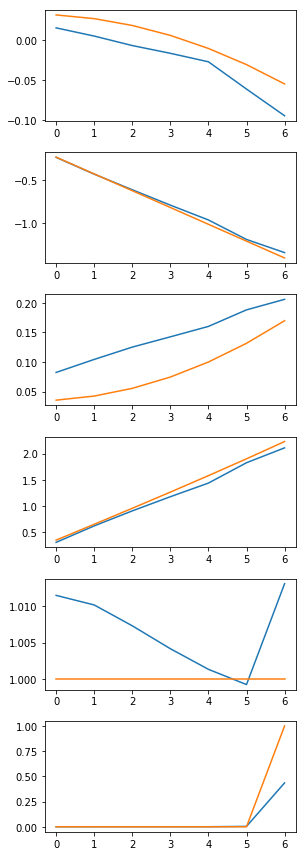

In [9]:
plt.figure(figsize=(8, 12))
for i in range(6):
    plt.subplot(6, 2, 2*i + 1)
    plt.plot(pState[:,i])   # draw the model predictions
    plt.subplot(6,2,2*i+1)
    
    ################################################################################
    # TODO: draw the real environment for comparison                               #
    ################################################################################
    plt.plot(tState[:,i])
    ################################################################################
    #                                 END OF YOUR CODE                             #
    ################################################################################
plt.tight_layout()